In [4]:
import json
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from Helper_Functions import *
from tqdm import tqdm
import time
from scipy.optimize import linear_sum_assignment
import warnings
import joblib
from scipy.ndimage import gaussian_filter
warnings.filterwarnings("ignore")

### Load Data:

In [5]:
a_outfielders,a_gk,_ = Load_Test_Data('Sample_Game_1_RawTrackingData_Away_Team.csv',half=2)
h_outfielders,h_gk,ball_pos = Load_Test_Data('Sample_Game_1_RawTrackingData_Home_Team.csv',half=2)

### Load Models:

In [6]:
model_x = joblib.load('Model_x.pkl')
model_y = joblib.load('Model_y.pkl')
results_x = model_x.fit()
results_y = model_y.fit()

### Parameters:

In [7]:
radius = 30
frames_per = 25

### Test Creator:

In [8]:
def Filter_Positions(frame):
    b_pos = ball_pos[frame]
    tlocs = h_outfielders[frame]
    olocs = a_outfielders[frame]
    tkeep = h_gk[frame]
    okeep = a_gk[frame]
    
    
    tkept = np.zeros(20)
    tgkkept = np.zeros(2)
    for m in range(10):
        distance= np.sqrt((tlocs[2*m] - b_pos[0])**2 + (tlocs[2*m + 1] - b_pos[1])**2)
        tkept[2*m:2*(m+1)]  = distance < radius
    tgkkept[:] = np.sqrt((tkeep[0] - b_pos[0])**2 + (tkeep[1] - b_pos[1])**2) < radius
    tlocs = tlocs[tkept==1]
    tkeep = tkeep[tgkkept==1] 
    
    okept = np.zeros(20)
    ogkkept = np.zeros(2)
    for m in range(10):
        distance = np.sqrt((olocs[2*m] - b_pos[0])**2 + (olocs[2*m + 1] - b_pos[1])**2)
        okept[2*m:2*(m+1)] = distance < radius
    ogkkept[:] = np.sqrt((okeep[0] - b_pos[0])**2 + (okeep[1] - b_pos[1])**2) < radius
    olocs = olocs[okept==1]
    okeep = okeep[ogkkept==1]
    
    tlocs = tlocs.reshape((int(len(tlocs)/2),2))
    tkeep = tkeep.reshape((int(len(tkeep)/2),2))
    olocs = olocs.reshape((int(len(olocs)/2),2))
    okeep = okeep.reshape((int(len(okeep)/2),2))
    return tlocs,tkeep,olocs,okeep,b_pos

### Fitting

In [9]:
def Ndist(x,mu,sigma):

    return np.sum(-(np.square(x-mu))/(2*(sigma**2)) - np.log((sigma**2)))



def Predict(all_positions,all_times,curr_frame,all_exog):
    if len(all_positions) > 100:
        all_positions = all_positions[-100:]
        all_times = all_times[-100:]
        curr = 100
        all_exog = all_exog[curr_frame-100:]
    else:
        curr = curr_frame
    models = [results_x,results_y]
    outputs = np.zeros((20,2,2))
    for m in range(20):
        for k in range(2):
            p = all_positions[:curr,m,k]
            t = all_times[:curr,m]
            exog = all_exog[:curr,k]
            p_smoothed = np.zeros(curr)
            t[t==-10] = 0
            discretes = np.arange(len(t)).astype(int)
            t = np.append(-50,t)
            p_filt= p[t[1:] != t[:-1]]
            
            
            
            t_filt = t[1:][t[1:] != t[:-1]]
            d_filt =discretes[t[1:] != t[:-1]]
            
            if len(p) > 1:
                index = np.max(np.arange(len(p_smoothed))[t[1:] != t[:-1]])
                
                
                if curr - index > 1:
                
                    for n in range(len(p_filt)-1):
                        p_smoothed[int(d_filt[n]):int(d_filt[n+1])] = np.linspace(p_filt[n],p_filt[n+1],int(d_filt[n+1] - d_filt[n]))
                    p_smoothed[int(d_filt[len(p_filt)-1])] = p_filt[len(p_filt)-1]
                    if len(p_smoothed) > 1 and index > 1 and len(np.unique(exog[:index+1])) > 2:
                        pred_results = models[k].apply(p_smoothed[:index+1],exog=exog[:index+1])

                        preds = pred_results.get_prediction(start=index, end=curr,exog = all_exog[index+1:curr+1,k])

                        outputs[m,k,0] = preds.predicted_mean[-1]
                        outputs[m,k,1] = preds.se_mean[-1]
                        #if curr - index == 1:
                        #    print(p_smoothed[:index+1])
                        #    print(p_filt[-1])
                        #    print(curr-index)
                        #    print(outputs[m,k,0])
                        #    print('_____________________________________________')
                    else:
                        outputs[m,k,0] = p[-1]
                        outputs[m,k,1] = (curr-index)*4
                else:
                    outputs[m,k,0] = p[-1]
                    outputs[m,k,1] = (curr-index)*4
            else:

                outputs[m,k,0] = p[-1]
                outputs[m,k,1] = (curr_frame+1)*4
    return outputs


initialise = True




curr_positions = np.zeros((22,2))
curr_times = (-10)*np.ones(22)

all_positions = np.zeros((15000,22,2))
all_times = np.zeros((15000,22))
true_times = np.zeros((15000,22))
visible = np.zeros((15000,22))
all_exog = np.zeros((15000,2))
for dat_num in range(min(15000,int(np.around(len(h_outfielders)/frames_per))-2)):
    frame = frames_per*dat_num
    tlocs,tkeep,olocs,okeep,b_pos = Filter_Positions(frame)
    all_exog[dat_num] = b_pos
all_exog = gaussian_filter(all_exog,sigma=4)
for dat_num in tqdm(range(min(15000,int(np.around(len(h_outfielders)/frames_per))-2))):
    frame = frames_per*dat_num
    t =dat_num*frames_per/25
    
    tlocs,tkeep,olocs,okeep,b_pos = Filter_Positions(frame)
    
    if initialise:
        for n,loc in enumerate(tlocs):
            curr_positions[n] = loc
            curr_times[n] = 0
            visible[dat_num,n] = 1
        other_ys = np.linspace(0,80,(10-n+2))
        for m in range(n,10):
            curr_positions[m] =[30,other_ys[m-n+1]]
            curr_times[m] = - 10


        for n,loc in enumerate(olocs):
            curr_positions[n+10] = loc
            curr_times[n+10] =  0
            visible[dat_num,n+10] = 1
        other_ys = np.linspace(0,80,(10-n+2))
        for m in range(n,10):
            curr_positions[m+10] =[90,other_ys[m-n+1]]
            curr_times[m+10] =  - 10



        if len(tkeep) > 0:
            curr_positions[20] = tkeep
            visible[dat_num,20] = 1
        else:
            curr_positions[20] = [10,40]

        if len(okeep) > 0:
            curr_positions[21] = okeep
            visible[dat_num,21] = 1
        else:
            curr_positions[21] = [110,40]
        initialise = False
        all_positions[dat_num] = curr_positions
        all_times[dat_num] = curr_times
        true_times[dat_num] = 0
        dat_num += 1
        

        continue




    outputs = Predict(all_positions[:dat_num],all_times[:dat_num],dat_num,all_exog)

    dists = np.zeros((10,len(tlocs)))
    for n in range(10):
        for m in range(len(tlocs)):
            dists[n,m] = Ndist(tlocs[m],outputs[n,:,0],outputs[n,:,1])
    row_indices, col_indices = linear_sum_assignment(-dists)
    for i, j in zip(row_indices, col_indices):
        curr_positions[i] = tlocs[j]
        curr_times[i] = t
        visible[dat_num,i] = 1


    dists = np.zeros((10,len(olocs)))
    for n in range(10):
        for m in range(len(olocs)):
            dists[n,m] = Ndist(olocs[m],outputs[n+10,:,0],outputs[n+10,:,1])
    row_indices, col_indices = linear_sum_assignment(-dists)
    for i, j in zip(row_indices, col_indices):
        curr_positions[i+10] = olocs[j]
        curr_times[i+10] = t
        visible[dat_num,i+10] = 1

    if len(tkeep) > 0:


        curr_positions[20] =tkeep
        curr_times[20] = t
        visible[dat_num,20] = 1

    if len(okeep) > 0:
       
        curr_positions[21] = okeep
        curr_times[21] = t
        visible[dat_num,21] = 1


    

    all_positions[dat_num] = curr_positions
    
    all_times[dat_num] = curr_times

    true_times[dat_num] = t
    



all_positions = all_positions[:dat_num]
all_times = all_times[:dat_num]
visible = visible[:dat_num]
true_times = true_times[:dat_num]
all_exog = all_exog[:dat_num]

100%|██████████| 3603/3603 [11:55<00:00,  5.03it/s]


In [17]:
len(np.unique(all_exog[dat_num-100:dat_num]))

2

### Create Smoothed Trajectories

In [17]:
mu = 0.6
velocities = np.zeros((dat_num-1,2))
for n in range(dat_num-1):
    allowed = (visible[n] == 1)&(visible[n+1] == 1)&(np.arange(22)<20)
    if np.sum(allowed) > 0:
        velocities[n] = np.mean(all_positions[n+1,allowed] - all_positions[n,allowed],0)*mu

filtered_positions = np.copy(all_positions)
filtered_positions_no_velocity = np.copy(all_positions)
filtered_positions_static = np.copy(all_positions)
for n in range(22):
    player_vis = visible[:,n] == 1
    vis_indices = np.arange(dat_num)[player_vis]
    vis_indices = np.append(vis_indices,dat_num-1)
    for old,new in zip(vis_indices[:-1],vis_indices[1:]):
        
        tstart = all_times[old,n]
        tend = all_times[new,n]
    
        pstart = all_positions[old,n]
        pend = all_positions[new,n]
        if tend == tstart:
            continue
        if n < 20:
            tot_veloc = np.sum(velocities[old:new-1],0)
            veloc_shifts = np.cumsum(velocities[old:new-1],0)
            veloc_shifts = np.append([[0,0]],veloc_shifts,axis=0)

            

            filtered_positions[old:new,n,0] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[0]-pstart[0]-tot_veloc[0]) + pstart[0] + veloc_shifts[:,0]
            filtered_positions[old:new,n,1] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[1]-pstart[1]-tot_veloc[1]) + pstart[1] + veloc_shifts[:,1]
            #filtered_positions[old:new,n,1] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[1]-pstart[1]) + pstart[1]
        else:
            filtered_positions[old:new,n,0] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[0]-pstart[0]) + pstart[0]
            filtered_positions[old:new,n,1] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[1]-pstart[1]) + pstart[1]
            
        
        filtered_positions_no_velocity[old:new,n,0] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[0]-pstart[0]) + pstart[0]
        filtered_positions_no_velocity[old:new,n,1] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[1]-pstart[1]) + pstart[1]

        filtered_positions_static[old:new,n,0] =  pstart[0]
        filtered_positions_static[old:new,n,1] = pstart[1]
        

### Varying Velocity Weight

We investigate the effect of varying the velocity weight

In [13]:
processed_positions = []
mu_range = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
for mu in mu_range:
    velocities = np.zeros((dat_num-1,2))
    for n in range(dat_num-1):
        allowed = (visible[n] == 1)&(visible[n+1] == 1)&(np.arange(22)<20)
        if np.sum(allowed) > 0:
            velocities[n] = np.mean(all_positions[n+1,allowed] - all_positions[n,allowed],0)*mu
    filtered_positions_mu = np.copy(all_positions)
    for n in range(22):
        player_vis = visible[:,n] == 1
        vis_indices = np.arange(dat_num)[player_vis]
        vis_indices = np.append(vis_indices,dat_num-1)
        for old,new in zip(vis_indices[:-1],vis_indices[1:]):
            
            tstart = all_times[old,n]
            tend = all_times[new,n]
        
            pstart = all_positions[old,n]
            pend = all_positions[new,n]
            if tend == tstart:
                continue
            if n < 20:
                tot_veloc = np.sum(velocities[old:new-1],0)
                veloc_shifts = np.cumsum(velocities[old:new-1],0)
                
                veloc_shifts = np.append([[0,0]],veloc_shifts,axis=0)

                

                filtered_positions_mu[old:new,n,0] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[0]-pstart[0]-tot_veloc[0]) + pstart[0] + veloc_shifts[:,0]
                filtered_positions_mu[old:new,n,1] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[1]-pstart[1]-tot_veloc[1]) + pstart[1] + veloc_shifts[:,1]
            else:
                filtered_positions_mu[old:new,n,0] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[0]-pstart[0]) + pstart[0]
                filtered_positions_mu[old:new,n,1] = ((true_times[old:new,n]-tstart)/(tend-tstart))*(pend[1]-pstart[1]) + pstart[1]
    processed_positions.append(filtered_positions_mu)
            

### Error Computation (In Phase)

In [19]:
def compute_in_phase_errors(filtered_positions:np.ndarray, file_path:str):
    """
    Compute the errors for a set of positions 
    """
    delays = np.zeros((len(filtered_positions),20))
    errors = np.zeros(len(filtered_positions))
    off_camera = np.zeros((len(filtered_positions)))
    all_errors = np.zeros((len(filtered_positions),20))
    for nn in range(30,len(filtered_positions)-30):
        delays[nn] = nn-all_times[nn,:20]
        
        h_guess = filtered_positions[nn,:10]
        a_guess = filtered_positions[nn,10:20]
        
        h_true = h_outfielders[nn*frames_per].reshape((10,2))
        a_true =  a_outfielders[nn*frames_per].reshape((10,2))
        
        dists_h = np.zeros((10,10))
        for n in range(10):
            for m in range(10):
                dists_h[n,m] =np.sum(np.square(h_true[n]-h_guess[m]))
        row_indices, col_indices = linear_sum_assignment(dists_h)
        tot = np.sum([dists_h[r,c] for r,c in zip(row_indices,col_indices)])
        all_errors[nn,:10] = [dists_h[r,c] for r,c in zip(row_indices,col_indices)]
        ptot = np.sum([dists_h[r,c]>0 for r,c in zip(row_indices,col_indices)])
        
        dists_a = np.zeros((10,10))
        for n in range(10):
            for m in range(10):
                dists_a[n,m] =np.sum(np.square(a_true[n]-a_guess[m]))
        row_indices, col_indices = linear_sum_assignment(dists_a)
        tot += np.sum([dists_a[r,c] for r,c in zip(row_indices,col_indices)])
        ptot += np.sum([dists_a[r,c]>0 for r,c in zip(row_indices,col_indices)])
        errors[nn] = tot/(1e-8+ptot)
        all_errors[nn,10:] = [dists_a[r,c] for r,c in zip(row_indices,col_indices)]
        off_camera[nn] = ptot
        
    real_est = all_errors[all_errors > 0]
    real_del = delays[all_errors > 0]

    print('Percentage within 5m:')
    print(str(np.around(100*np.sum(real_est < 25)/len(real_est),2)) +'%')
    print(' ')
    print('Percentage within 10m:')
    print(str(np.around(100*np.sum(real_est < 100)/len(real_est),2)) +'%')
    print(' ')
    print('RMSE:')
    print(str(np.around(np.sqrt(np.mean(real_est)),2)) + 'm')
    print(' ')
    print('MAE:')
    print(str(np.around(np.mean(np.sqrt(real_est)),2)) + 'm')
    np.save(file_path,all_errors)

compute_in_phase_errors(filtered_positions, '2H.npy')
compute_in_phase_errors(filtered_positions_no_velocity, '2H_no_velocity.npy')
compute_in_phase_errors(filtered_positions_static, '2H_static.npy')
for index, positions in enumerate(processed_positions):
    print('______________')
    print(f'Results for mu = {mu_range[index]}')
    compute_in_phase_errors(positions, f'2H_mu_{mu_range[index]}.npy')

Percentage within 5m:
50.47%
 
Percentage within 10m:
76.26%
 
RMSE:
9.71m
 
MAE:
6.94m
Percentage within 5m:
41.58%
 
Percentage within 10m:
67.21%
 
RMSE:
12.08m
 
MAE:
8.74m
Percentage within 5m:
17.85%
 
Percentage within 10m:
36.63%
 
RMSE:
21.66m
 
MAE:
17.09m
______________
Results for mu = 0
Percentage within 5m:
41.58%
 
Percentage within 10m:
67.21%
 
RMSE:
12.08m
 
MAE:
8.74m
______________
Results for mu = 0.1
Percentage within 5m:
43.36%
 
Percentage within 10m:
69.27%
 
RMSE:
11.47m
 
MAE:
8.28m
______________
Results for mu = 0.2
Percentage within 5m:
45.1%
 
Percentage within 10m:
71.42%
 
RMSE:
10.93m
 
MAE:
7.87m
______________
Results for mu = 0.3
Percentage within 5m:
47.1%
 
Percentage within 10m:
73.17%
 
RMSE:
10.47m
 
MAE:
7.51m
______________
Results for mu = 0.4
Percentage within 5m:
49.0%
 
Percentage within 10m:
74.49%
 
RMSE:
10.11m
 
MAE:
7.23m
______________
Results for mu = 0.5
Percentage within 5m:
50.11%
 
Percentage within 10m:
75.57%
 
RMSE:
9.85m
 


### Error Computation (Out of Phase)

In [20]:
def compute_out_of_phase_errors(filtered_positions, file_path):
    """
    Compute the out of phase errors for different positions
    """
    delays = np.zeros((len(filtered_positions),20))
    errors = np.zeros(len(filtered_positions))
    off_camera = np.zeros((len(filtered_positions)))
    all_errors = np.zeros((len(filtered_positions),20))
    for nn in range(30,len(filtered_positions)-30):
        delays[nn] = nn-all_times[nn,:20]
        
        h_guess = 0.5*(filtered_positions[nn,:10] + filtered_positions[nn+1,:10] )
        a_guess = 0.5*(filtered_positions[nn,10:20] + filtered_positions[nn+1,10:20])
        
        h_true = h_outfielders[nn*frames_per + int(0.5*frames_per)].reshape((10,2))
        a_true =  a_outfielders[nn*frames_per+ int(0.5*frames_per)].reshape((10,2))
        
        dists_h = np.zeros((10,10))
        for n in range(10):
            for m in range(10):
                dists_h[n,m] =np.sum(np.square(h_true[n]-h_guess[m]))
        row_indices, col_indices = linear_sum_assignment(dists_h)
        tot = np.sum([dists_h[r,c] for r,c in zip(row_indices,col_indices)])
        all_errors[nn,:10] = [dists_h[r,c] for r,c in zip(row_indices,col_indices)]
        ptot = np.sum([dists_h[r,c]>0 for r,c in zip(row_indices,col_indices)])
        
        dists_a = np.zeros((10,10))
        for n in range(10):
            for m in range(10):
                dists_a[n,m] =np.sum(np.square(a_true[n]-a_guess[m]))
        row_indices, col_indices = linear_sum_assignment(dists_a)
        tot += np.sum([dists_a[r,c] for r,c in zip(row_indices,col_indices)])
        ptot += np.sum([dists_a[r,c]>0 for r,c in zip(row_indices,col_indices)])
        errors[nn] = tot/(1e-8+ptot)
        all_errors[nn,10:] = [dists_a[r,c] for r,c in zip(row_indices,col_indices)]
        off_camera[nn] = ptot
        
    real_est = all_errors[all_errors > 0]
    real_del = delays[all_errors > 0]

    print('Percentage within 5m:')
    print(str(np.around(100*np.sum(real_est < 25)/len(real_est),2)) +'%')
    print(' ')
    print('Percentage within 10m:')
    print(str(np.around(100*np.sum(real_est < 100)/len(real_est),2)) +'%')
    print(' ')
    print('RMSE:')
    print(str(np.around(np.sqrt(np.mean(real_est)),2)) + 'm')
    print(' ')
    print('MAE:')
    print(str(np.around(np.mean(np.sqrt(real_est)),2)) + 'm')
    np.save(file_path,all_errors)
compute_out_of_phase_errors(filtered_positions, '2H_O.npy')
compute_out_of_phase_errors(filtered_positions_no_velocity,'2H_O_no_velocity.npy')
compute_in_phase_errors(filtered_positions_static, '2H_O_static.npy')
for index, positions in enumerate(processed_positions):
    print('______________')
    print(f'Results for mu = {mu_range[index]}')
    compute_out_of_phase_errors(positions, f'2H_O_mu_{mu_range[index]}.npy')

Percentage within 5m:
77.2%
 
Percentage within 10m:
89.05%
 
RMSE:
6.61m
 
MAE:
3.3m
Percentage within 5m:
72.94%
 
Percentage within 10m:
84.79%
 
RMSE:
8.23m
 
MAE:
4.15m
Percentage within 5m:
17.85%
 
Percentage within 10m:
36.63%
 
RMSE:
21.66m
 
MAE:
17.09m
______________
Results for mu = 0
Percentage within 5m:
72.94%
 
Percentage within 10m:
84.79%
 
RMSE:
8.23m
 
MAE:
4.15m
______________
Results for mu = 0.1
Percentage within 5m:
73.79%
 
Percentage within 10m:
85.78%
 
RMSE:
7.81m
 
MAE:
3.93m
______________
Results for mu = 0.2
Percentage within 5m:
74.66%
 
Percentage within 10m:
86.77%
 
RMSE:
7.44m
 
MAE:
3.74m
______________
Results for mu = 0.3
Percentage within 5m:
75.6%
 
Percentage within 10m:
87.55%
 
RMSE:
7.13m
 
MAE:
3.57m
______________
Results for mu = 0.4
Percentage within 5m:
76.46%
 
Percentage within 10m:
88.25%
 
RMSE:
6.89m
 
MAE:
3.44m
______________
Results for mu = 0.5
Percentage within 5m:
77.03%
 
Percentage within 10m:
88.71%
 
RMSE:
6.71m
 
MAE:
3

In [24]:
len(all_positions)

3602

In [25]:
np.mean(all_errors == 0)*20

10.88423098278734

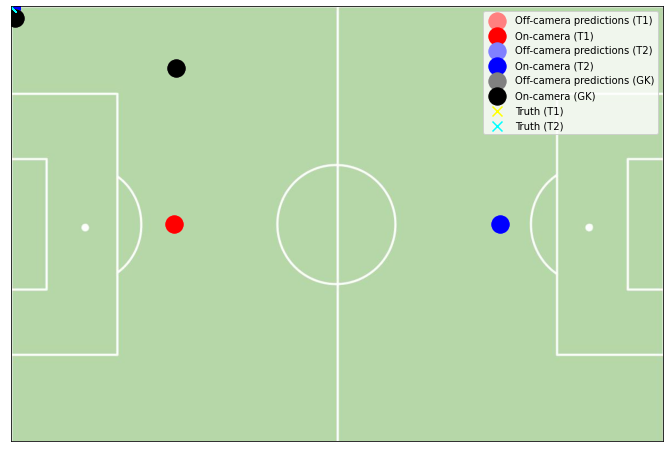

[36.33876293 35.8637504  27.86846739 23.47033586 21.45693922 41.24353387
 32.99644269 28.88506607 43.09145927 40.14036759 46.89126469 54.7855968
 23.24968306 46.09658458 39.98863019 56.39103158 49.65129833 64.729234
 35.06243424 32.18265081]


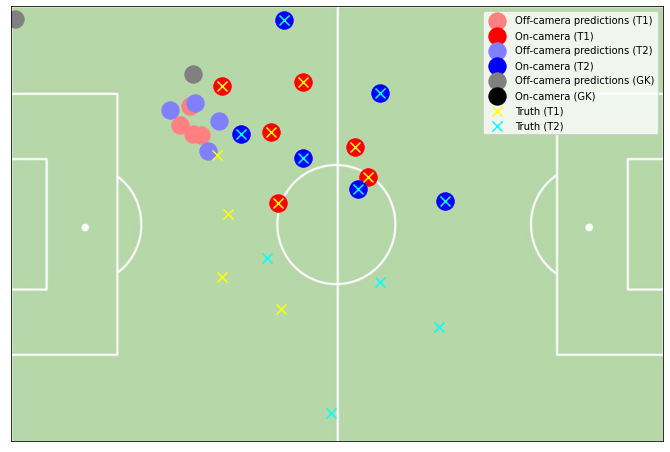

[18.20982442 11.8669699   5.02276813  0.29104089 19.14791469 11.21233575
  0.47187286  0.14516542  0.27712993  0.29934575  0.13246962  0.15072836
 21.12222811 18.25346076 17.31682033 20.71592176 16.78727523 43.29921862
  0.2298369  10.78018886]


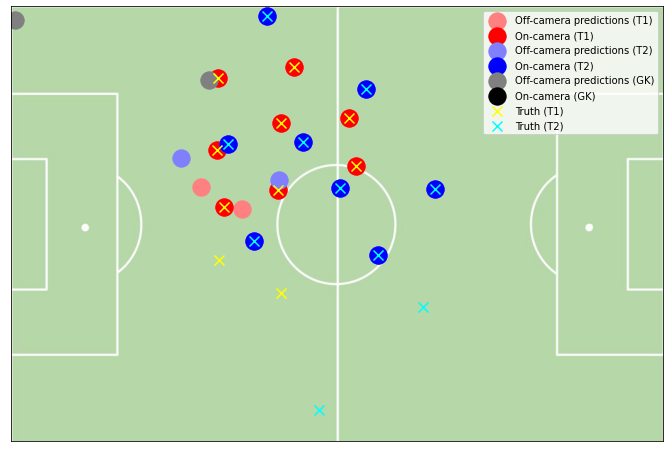

[ 6.61244894  0.29864601  0.32752771  0.32452649  8.36267321  0.23035034
  0.47567468  0.31236037  0.5861985   0.39268802  0.42310401  0.18427469
 12.5323367  15.41504987  0.4428     11.63679222  6.16156818 33.98229764
  0.21821283  0.27367631]


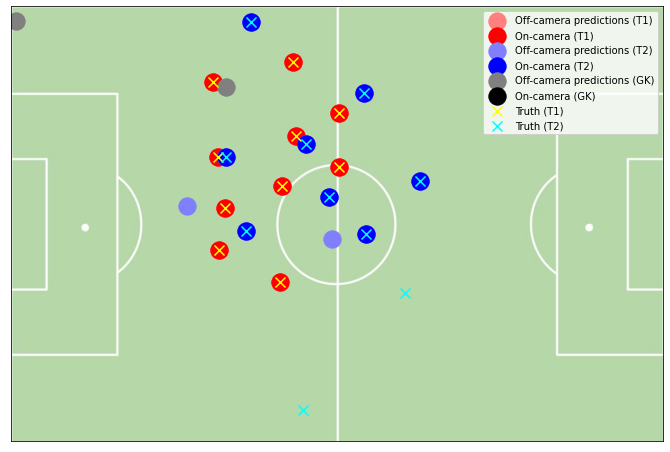

[ 0.4919537   0.30718594  0.10724421  0.29781025  0.3990832   0.47407358
  0.46131018  0.29053943  0.31213177  0.49786155  0.1202983   0.23227294
  7.85218864 10.28676011  0.18635718  0.62053657  0.31120906 34.1497584
  2.0659737   0.0855383 ]


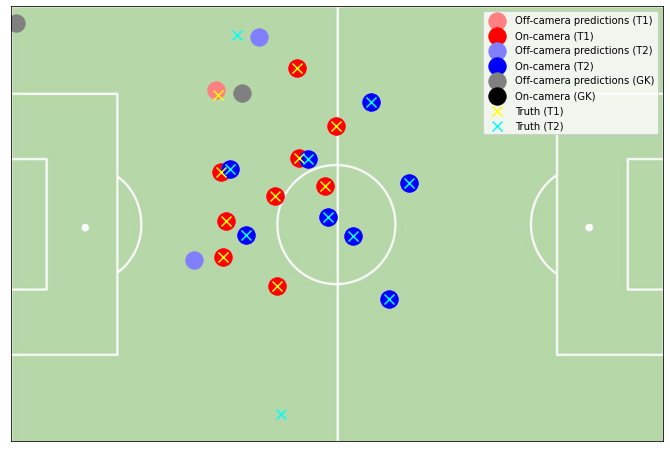

[ 0.52661956  0.30515104  0.23297699  1.43188641  0.25338224  0.37022047
  0.36302733  0.67787538  0.11766393  0.19728325  0.21043735  0.17717122
  0.24856138  0.3547978   0.3193566   0.27483151  0.32242339 26.19445352
  5.52518817  0.22964015]


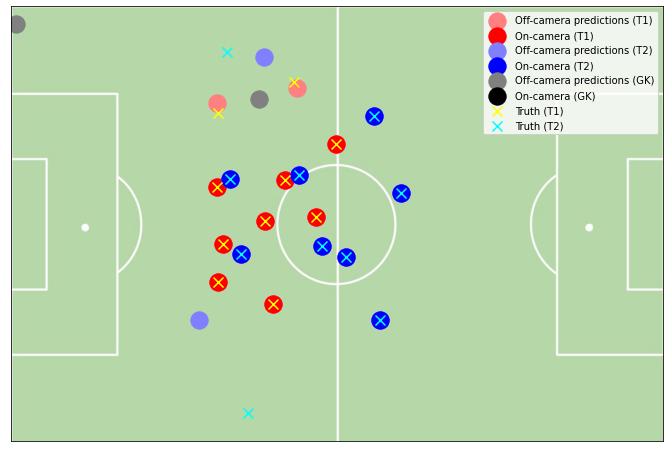

[ 0.26922853  0.17826273  0.20861179  2.10020419  0.1784584   0.22356028
  0.12008547  2.02818321  0.10035637  0.18236941  0.20180436  0.09525461
  0.15424137  0.12098149  0.14034885  0.15132112  0.24994911 12.86850764
  7.88652908  0.26781785]


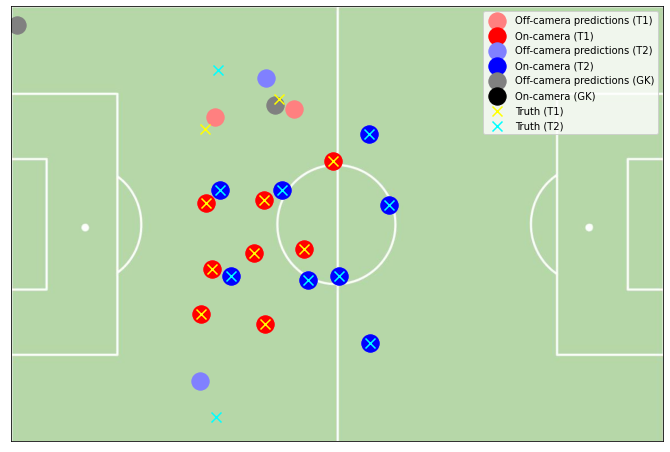

[0.18426068 0.06104425 0.16727714 3.88685704 0.09818595 0.10564847
 0.06788225 4.26961782 0.06646864 0.21102606 1.00174758 0.11118633
 0.10903669 0.12338493 0.05616013 0.04499111 0.1920126  3.46459148
 9.72930279 0.17873657]


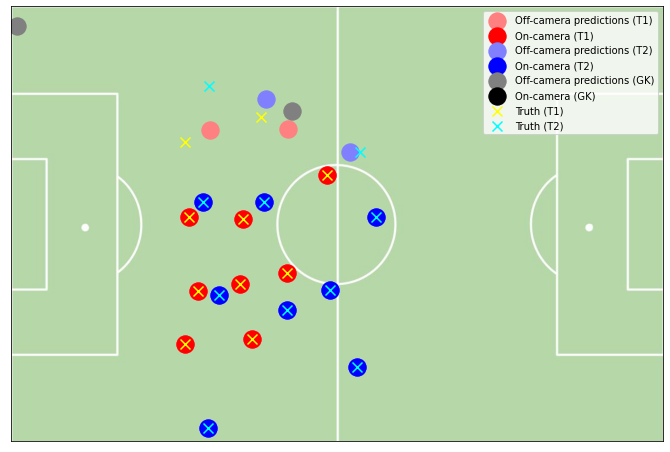

[ 0.38469754  0.19122479  0.03284692  6.27144056  0.29618643  0.10051169
  0.02941088  6.5635568   1.90920601  0.20698879  2.56580191  0.35898885
  0.07440968  0.22217588  0.10708968  0.1087921   0.24742126  0.26386209
 11.57884738  0.07126402]


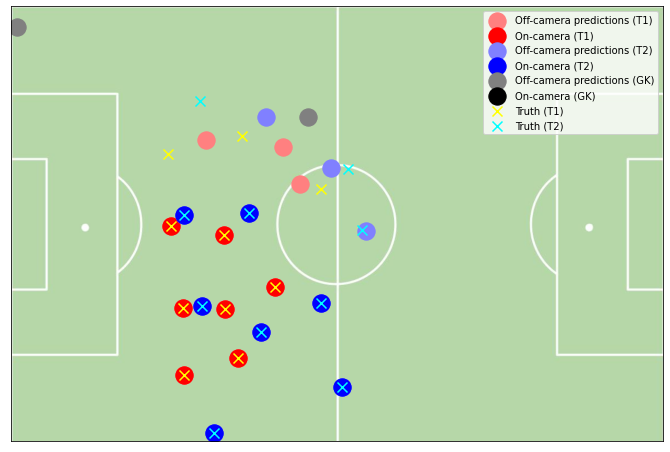

[ 0.3000174   0.16060336  0.84321414  8.32333872  0.05531727  0.09074117
  0.71368309  9.05656426  5.59722229  0.16406243  3.47721626  1.41680901
  0.06494459  0.30483071  1.10388291  0.21463606  0.32222352  0.09863468
 13.53780614  1.24672769]


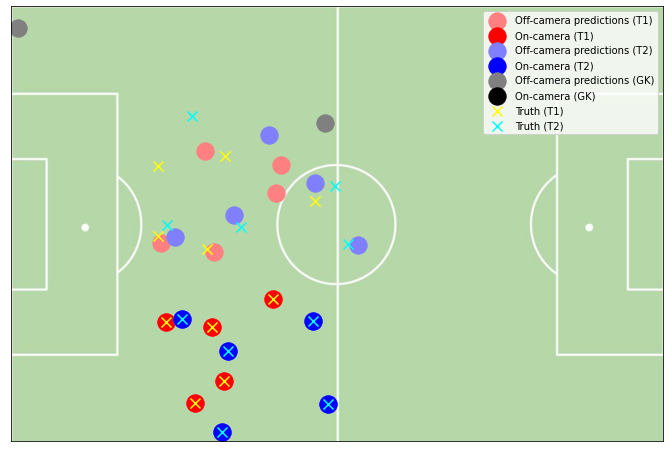

[ 0.52068205  0.36675463  2.19750848  9.87115165  0.567397    0.40573213
  2.03423224 10.65934273  8.27583391  0.04655491  3.69753249  2.43479742
  0.17261564  0.36483158  4.22298705  0.34861692  0.07368718  0.33037506
 15.76809424  4.0364506 ]


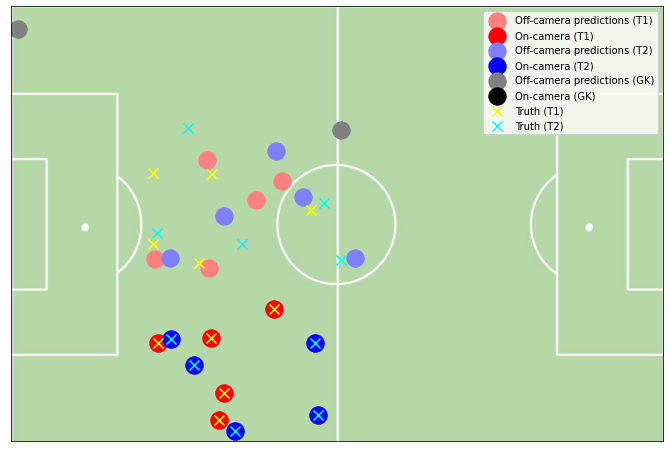

[ 0.27849309  0.41503523  3.12469469 11.16003836  0.3928727   0.34201316
  1.42064965  8.1722685   6.30447424  0.19860363  4.21254396  3.00740204
  0.3713881   0.47048231  7.98172705  0.28748899  0.58126872  0.20235612
 18.17935843  6.13144463]


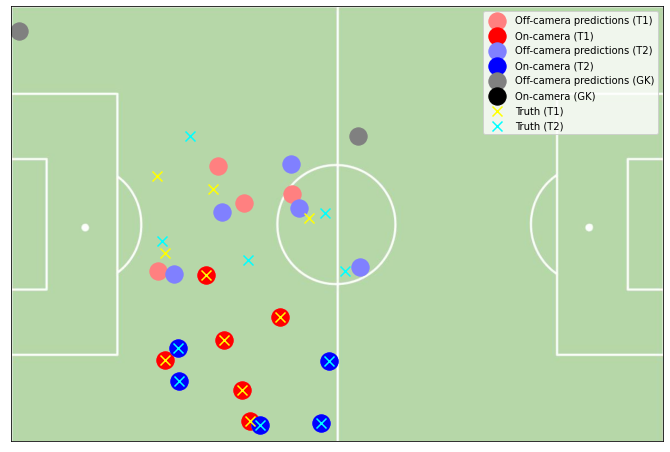

[ 0.61824008  0.1494443   4.16430583 11.47970235  0.2671476   0.07155893
  0.72396138  4.43993074  4.65294533  0.1701886   9.53399283  1.66950887
  0.04531137  0.18141147 12.80219377  0.23132315  0.38869834  0.28512566
 14.21096675  6.81701376]


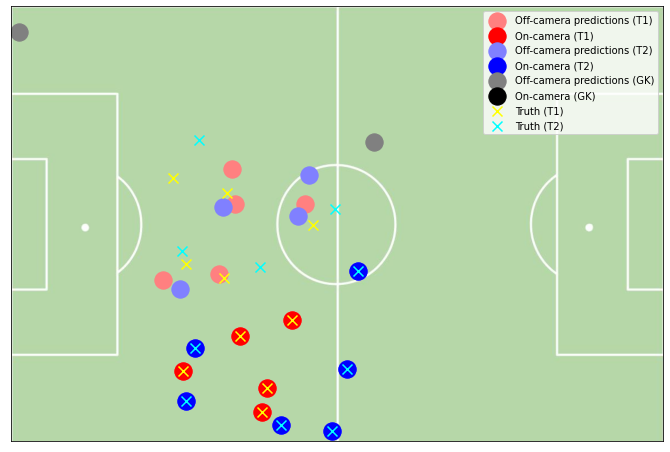

[ 0.35014534  0.33792046  6.1443201   9.6964157   0.35725604  0.06825628
  1.96986502  3.99237364  3.48395702  0.08020898  5.9820452   0.67411638
  0.25975288  0.19718103 10.03963392  0.20991922  0.16440195  0.18470268
 11.5317731   7.09264303]


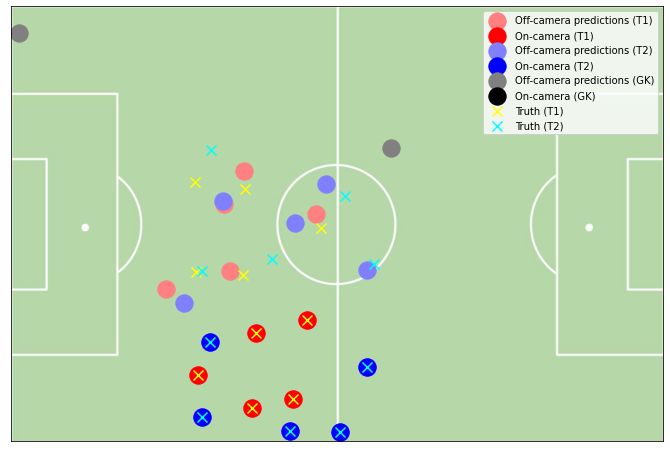

[0.02468117 0.5384039  5.71718902 3.94786288 0.42592243 0.28872222
 2.84977192 2.90127544 2.33396662 0.09151612 3.26544295 2.50417588
 0.0772     0.12935672 5.88334218 0.36511259 0.28712812 0.11743458
 7.24590209 5.75779978]


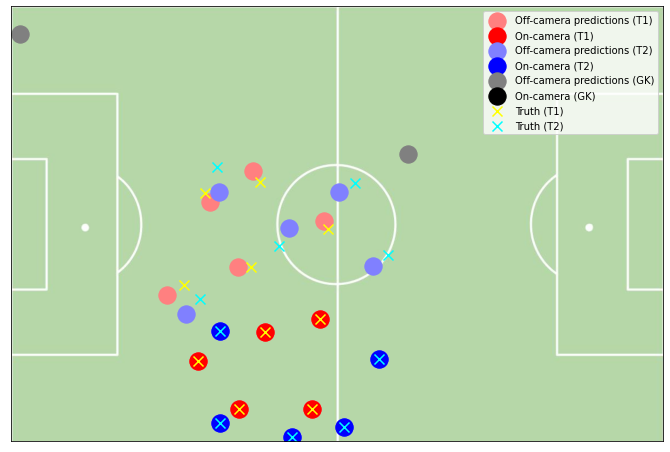

[0.28462045 0.1421381  1.9133666  0.72804702 0.5523131  0.19577947
 1.57953277 2.17491123 1.22590186 0.19916184 3.83002747 3.69575201
 0.13425543 0.38957659 1.67505269 0.62653077 0.46092498 0.22384754
 2.32166514 1.90771755]


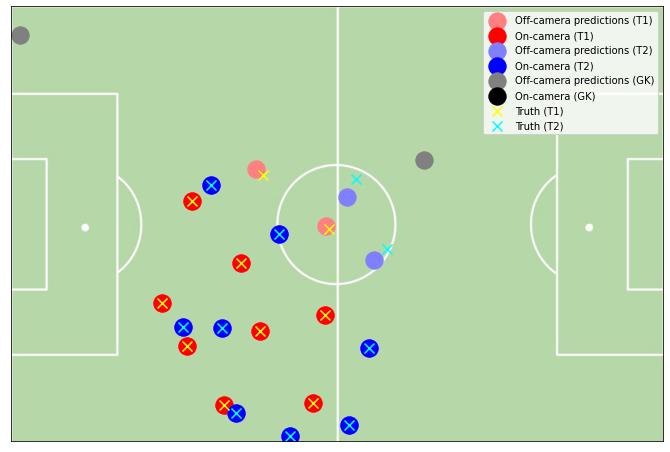

[0.21904118 0.3979908  0.67204419 0.38205303 0.05283067 0.31764716
 0.36554945 0.70832172 0.15324921 0.08955088 3.04366992 1.97375648
 0.42994027 0.16165791 0.40567593 0.17330666 0.16768983 0.31030701
 0.19427867 0.41665991]


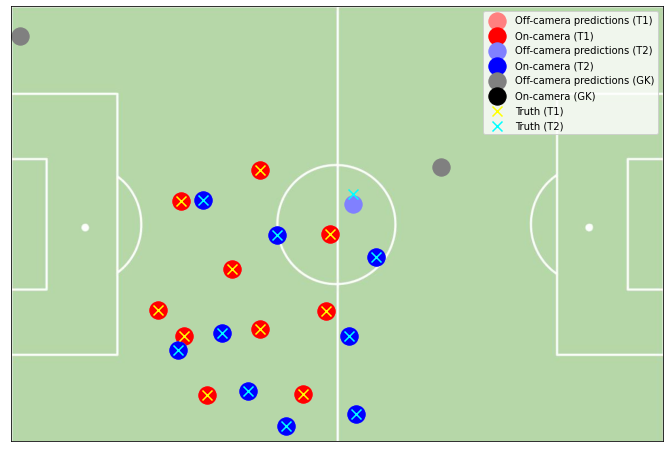

[0.46462337 0.44729105 0.48167524 1.07234199 0.38003726 0.3680463
 0.58573332 0.33367415 0.38219346 0.35183291 0.91789443 0.33215304
 0.21358989 0.43137807 0.25009926 0.70910662 0.20200356 0.24866757
 0.35217751 0.41130913]


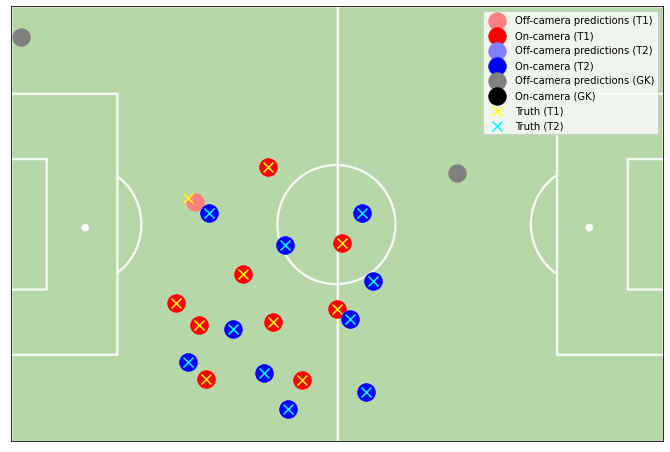

[0.85423511 0.25677836 0.18914053 1.5960637  0.17567208 0.04488786
 0.21241139 0.1376327  0.1526629  0.1537922  0.22225184 0.30131479
 0.46076267 0.20259793 0.07303944 0.20748128 0.05333254 0.23824592
 0.66496969 0.70387372]


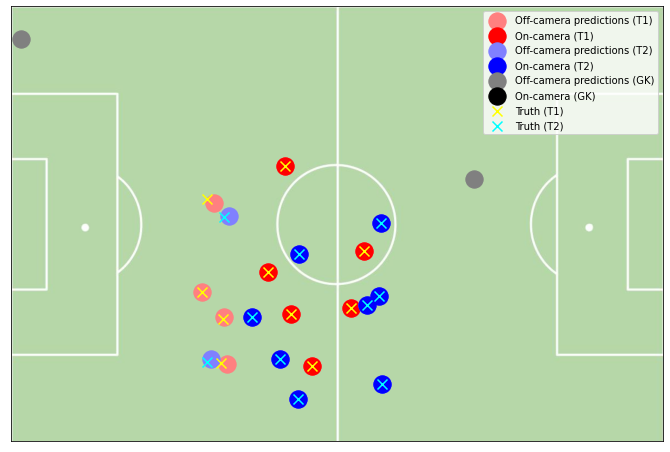

[0.2887489  0.45467769 0.30965215 0.787078   0.30542122 0.39683326
 0.51857362 0.06190218 0.41385432 0.27303721 0.33426917 0.23947576
 0.39834703 0.39296336 0.09312529 0.52243878 0.27180118 0.18147176
 0.32248926 0.59772009]


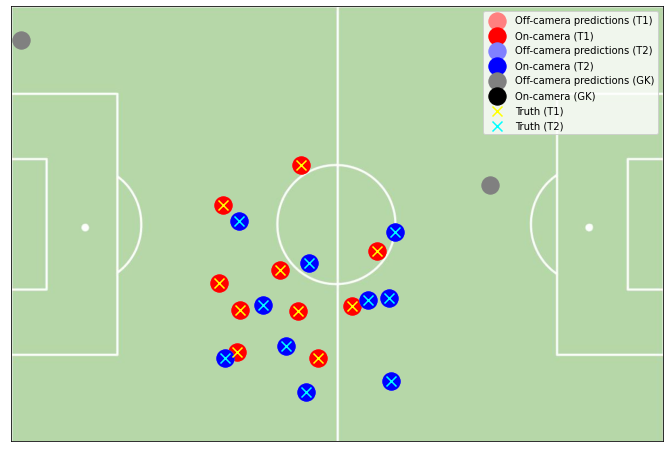

[0.5443612  0.15144755 0.26146724 0.32309584 0.2288493  0.15811793
 0.20359057 0.13555279 0.31912129 0.08653416 0.48235825 0.34837589
 0.46638456 0.3756443  0.13084953 0.06864284 0.06603393 0.21720451
 0.26343758 0.61890487]


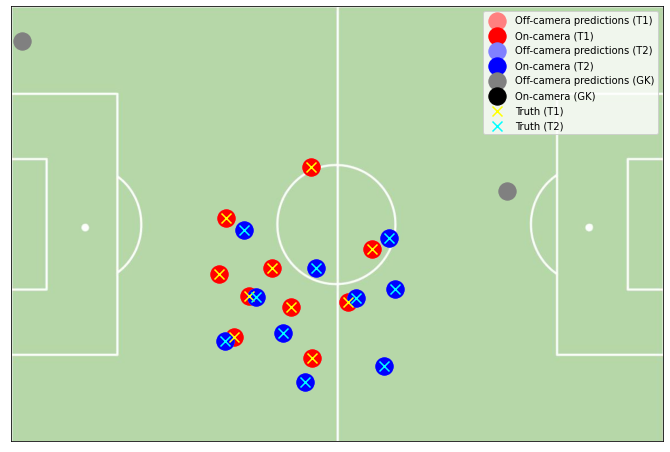

[0.35705445 0.34335754 0.20881379 0.30891844 0.21056305 0.40755505
 0.42242216 0.25770681 0.23711272 0.04790157 0.25893883 0.0173078
 0.14889365 0.39386333 0.13079465 0.3218412  0.33633436 0.23941863
 0.20998181 0.1858141 ]


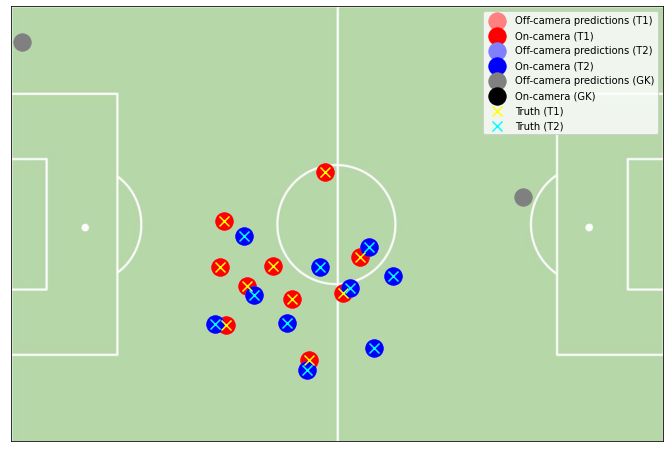

[0.48415836 0.12096809 0.06236538 0.3425133  0.31669316 0.26780777
 0.1484512  0.29964806 0.26235884 0.12590346 0.4749109  0.25625277
 0.42857475 0.35587436 0.1741613  0.21886334 0.40401604 0.31154968
 0.28819001 0.44308487]


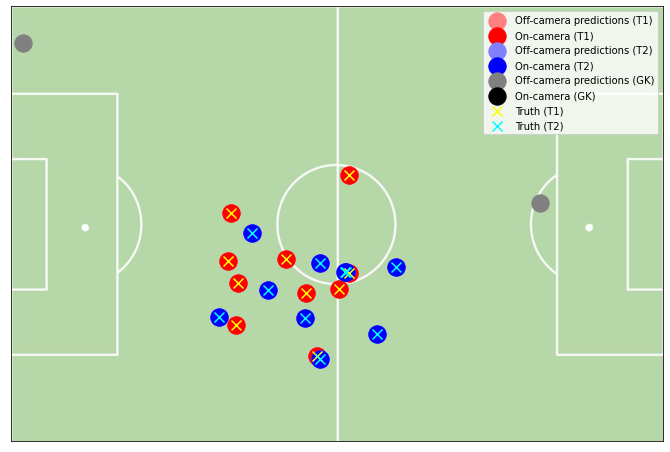

[0.07900684 0.2503492  0.04644136 0.21353407 0.19532465 0.11138761
 0.06991223 0.2314     0.58592081 0.12360259 1.09105197 0.27795921
 0.2345062  0.15035811 0.40526396 0.46014711 0.25310622 0.15250036
 0.18560388 0.19763158]


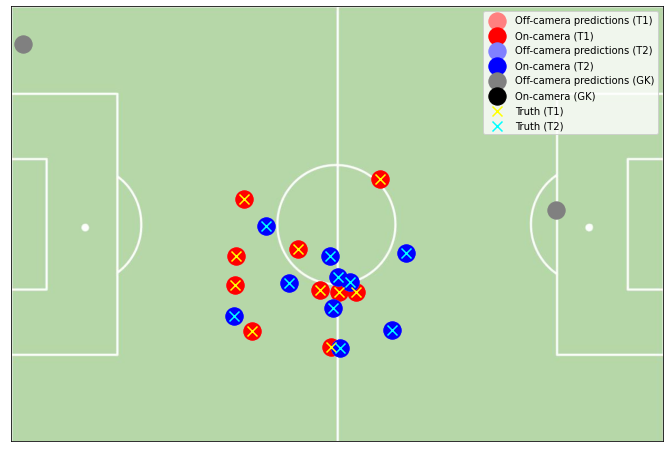

[0.56640513 0.66971871 0.6014029  0.18118411 0.18277954 0.2005309
 0.25382986 0.06535075 0.65735765 0.33631777 0.44653443 0.32934972
 0.44266412 0.14312624 0.27100288 0.36584658 0.02249    0.15366926
 0.23622405 0.48464444]


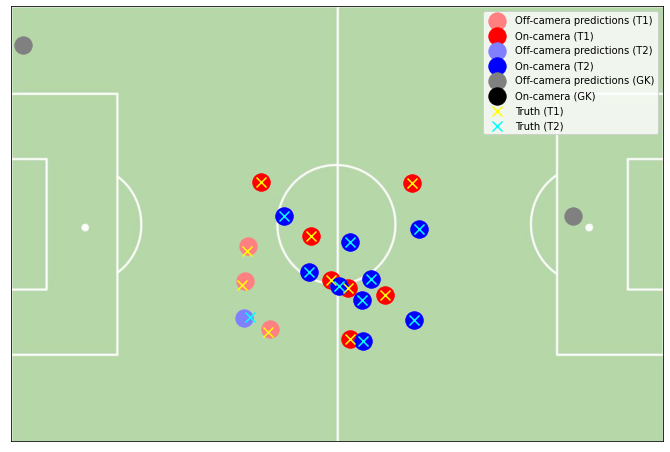

[1.12197592 1.16570877 1.6858037  0.07355678 0.02373605 0.08246915
 0.26671633 0.14726194 0.3635248  0.39889848 0.34785773 0.22238057
 0.34114208 0.13040552 0.3405337  0.4592307  0.27011849 0.19519928
 0.33087835 1.20616623]


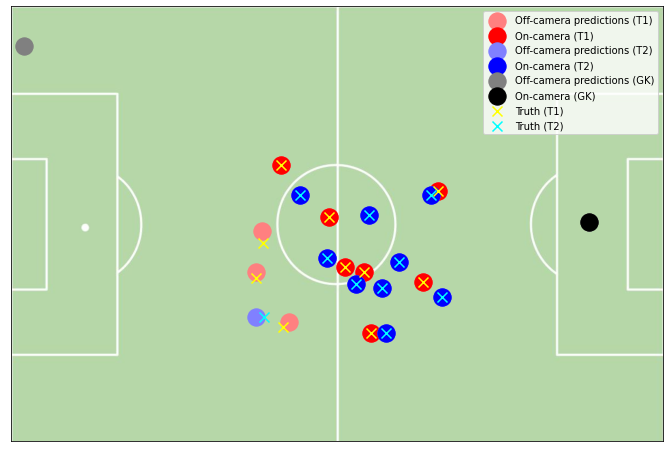

[1.82535714 1.11575165 2.64163264 0.26165573 2.06427225 0.32217511
 0.32745736 0.54571293 0.28701672 0.17766936 0.12261745 0.39548922
 0.25179357 0.24476111 0.01449966 0.23882713 0.38415205 1.80557614
 0.21697447 1.63794556]


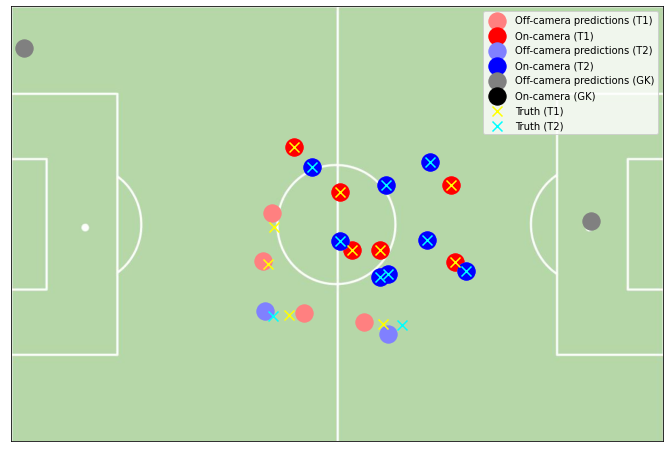

[4.0198279  1.18453482 1.39247423 0.25347923 4.58368067 0.27477707
 0.40781368 0.61943758 0.40414359 0.28353483 0.14649355 0.30929112
 0.50400397 0.37172942 0.40443328 0.74265042 1.21756322 3.53494716
 0.41303603 2.25206552]


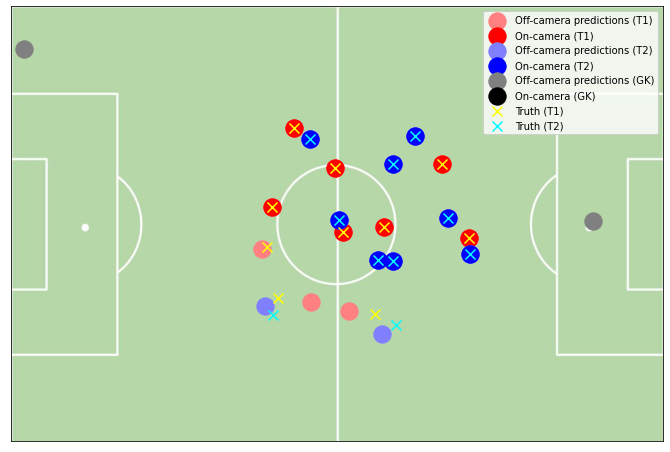

[7.97410727 0.9101862  0.21728102 0.34840373 5.37446655 0.11810775
 0.24144167 0.34252667 0.2794584  0.14096652 0.20501132 0.19188747
 0.39502608 0.17521644 0.44119347 0.20866097 0.2027057  2.78124236
 0.50359988 1.87822811]


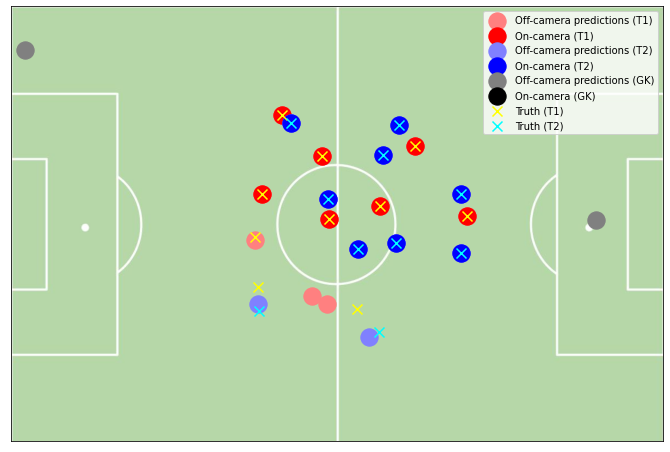

[11.86054576  0.46270147  0.22565992  0.19558159  6.05688906  0.04220521
  0.09394637  0.0966354   0.14449913  0.0947426   0.16985935  0.11218841
  0.14875698  0.10669508  0.18846114  0.0276      0.0911456   1.72683074
  0.14196788  1.62237994]


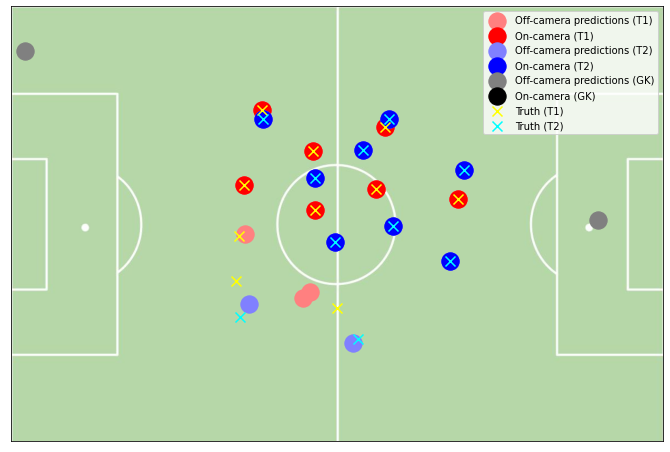

[12.41083844  1.51785196  0.7932694   0.16622599  4.46154212  0.27309962
  0.27106376  0.58732454  0.042       0.18157588  0.08042015  0.30198841
  0.1401863   0.08858442  0.25348207  0.12966912  0.25944988  0.85667468
  0.24682042  4.09517655]


In [36]:
for index in range(0,30):
    img = plt.imread('Football Pitch.jpg')
    plt.figure(figsize = (12,8))
    plt.imshow(img)
    plt.scatter(10*filtered_positions[index,:10,0],10*filtered_positions[index,:10,1],marker='o',label = 'Off-camera predictions (T1)',s=300,color = (1,0.5,0.5,1))
    plt.scatter(10*filtered_positions[index,:10,0][visible[index,:10] == 1],10*all_positions[index,:10,1][visible[index,:10] == 1],marker='o',label = 'On-camera (T1)',s=300,color = (1,0,0,1))

    plt.scatter(10*filtered_positions[index,10:20,0],10*filtered_positions[index,10:20,1],marker='o',label = 'Off-camera predictions (T2)',s=300,color=(0.5,0.5,1,1))
    plt.scatter(10*filtered_positions[index,10:20,0][visible[index,10:20] == 1],10*all_positions[index,10:20,1][visible[index,10:20] == 1],marker='o',label = 'On-camera (T2)',s=300,color=(0,0,1,1))

    plt.scatter(10*filtered_positions[index,20:,0],10*filtered_positions[index,20:,1],marker='o',label = 'Off-camera predictions (GK)',s=300,color = (0.5,0.5,0.5,1))
    plt.scatter(10*filtered_positions[index,20:,0][visible[index,20:] == 1],10*filtered_positions[index,20:,1][visible[index,20:] == 1],marker='o',label = 'On-camera (GK)',s=300,color=(0,0,0,1))
    
    plt.scatter(10*h_outfielders[index*frames_per].reshape((10,2))[:,0],10*h_outfielders[index*frames_per].reshape((10,2))[:,1],label = 'Truth (T1)',color = (1,1,0),marker = 'x',s=100)
    plt.scatter(10*a_outfielders[index*frames_per].reshape((10,2))[:,0],10*a_outfielders[index*frames_per].reshape((10,2))[:,1],label = 'Truth (T2)',color = (0,1,1),marker = 'x',s=100)
    plt.xticks([])
    plt.yticks([])
    plt.legend()
    plt.show()
    print(np.sqrt(all_errors[index]))